Взять CIFAR100 и обучить resnet18 с нуля на нем

Определить легкие и тяжелые объекты по лоссам итоговой модели

Взять другую модель и обучить её для CIFAR100  двумя способами:

1)объекты в рандомном порядке n эпох

2)чем больше номер эпохи чем больше вероятность выбрать сложный объект 

(да,распределение на индексах:вероятность выбрать объект сначала тем меньше,тем он сложнее,по ходу обучения распределение выходит на равномерное)

#1
Load vgg16_bn model pretrained on CIFAR100 and get losses for train_data with it

In [1]:
import torch
model_for_weights = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt


  0%|          | 0.00/58.4M [00:00<?, ?B/s]

In [2]:
model_for_weights.eval()
print()

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

from tqdm import tqdm

In [4]:
set_seed(42)

In [5]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

In [6]:
def get_loaders(data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
train_loader,test_loader = get_loaders(shuffles=[False,False])

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model_for_weights = model_for_weights.to(device)

In [10]:
loss_function = nn.CrossEntropyLoss(reduction='none')
loss_per_object = []
with torch.no_grad():
  for x,y in  tqdm(train_loader):
      x, y = x.to(device), y.to(device)
      preds = model_for_weights(x)
      loss = loss_function(preds,y)
      loss_per_object.append(loss)

loss_per_object = torch.hstack(loss_per_object)

100%|██████████| 1563/1563 [00:08<00:00, 188.35it/s]


In [11]:
loss_per_object.shape

torch.Size([50000])

Make dict to save loss history on test_data for different curriclum modes

In [12]:
N_EPOCHS = 10
losses_train_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}
losses_val_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}

1)Random

In [13]:
from torchvision.models import resnet18

model = resnet18(weights='DEFAULT')
model.fc = nn.Linear(512,100)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
train_loader,test_loader = get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss_function = nn.CrossEntropyLoss()
model.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [16]:
for x,y in train_loader:
  print(x.shape,y.shape)
  break

x = x.to(device)
output = model(x)
print(output.shape)

y = y.to(device)
loss = loss_function(output,y)
loss

torch.Size([32, 3, 32, 32]) torch.Size([32])
torch.Size([32, 100])


tensor(5.0416, device='cuda:0', grad_fn=<NllLossBackward0>)

In [17]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  model.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')
  losses_train_history['random'].append(train_loss / train_len)
  losses_val_history['random'].append(val_loss / val_len)

100%|██████████| 313/313 [00:01<00:00, 250.52it/s]


epoch 0: train loss:2.8231565952301025 val loss:2.0315730571746826


100%|██████████| 313/313 [00:01<00:00, 249.18it/s]


epoch 1: train loss:1.9778093099594116 val loss:1.8031129837036133


100%|██████████| 313/313 [00:01<00:00, 238.45it/s]


epoch 2: train loss:1.692697286605835 val loss:1.676113486289978


100%|██████████| 313/313 [00:01<00:00, 208.97it/s]


epoch 3: train loss:1.4851351976394653 val loss:1.6240078210830688


100%|██████████| 313/313 [00:01<00:00, 201.86it/s]


epoch 4: train loss:1.3275532722473145 val loss:1.5865141153335571


100%|██████████| 313/313 [00:01<00:00, 199.57it/s]


epoch 5: train loss:1.1910167932510376 val loss:1.5779637098312378


100%|██████████| 313/313 [00:01<00:00, 210.08it/s]


epoch 6: train loss:1.0800920724868774 val loss:1.5721746683120728


100%|██████████| 313/313 [00:01<00:00, 249.56it/s]


epoch 7: train loss:0.9807401299476624 val loss:1.5997682809829712


100%|██████████| 313/313 [00:01<00:00, 249.27it/s]


epoch 8: train loss:0.895101010799408 val loss:1.595463752746582


100%|██████████| 313/313 [00:01<00:00, 243.72it/s]

epoch 9: train loss:0.8186473846435547 val loss:1.6339954137802124


In [18]:
val_acc = 0
model.eval()
for x,y in train_loader:
  x,y = x.to(device), y.to(device)
  logits = model(x)
  preds = logits.max(1)[1]
  val_acc += (y == preds).sum()

val_acc / len(train_loader) / 32

tensor(0.8718, device='cuda:0')

In [19]:
def get_loaders_weighted(weights,data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[False, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=False)                     
 
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, sampler = sampler,
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)
    
    return train_loader, test_loader

2)hard first

In [39]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=1e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [40]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  if i < n_epochs//2:
    weights = 1. / (loss_per_object + 1.0)**(-0.5) 
  else:
    weigths = np.array([1]*len(loss_per_object))
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['hard first'].append(train_loss / train_len)
  losses_val_history['hard first'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 183.62it/s]


epoch 0: train loss:2.830085515975952 val loss:2.052398920059204
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 186.28it/s]


epoch 1: train loss:1.9896706342697144 val loss:1.7817739248275757
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 199.74it/s]


epoch 2: train loss:1.6891833543777466 val loss:1.6690539121627808
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 169.68it/s]


epoch 3: train loss:1.482007622718811 val loss:1.611411452293396
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 170.60it/s]


epoch 4: train loss:1.3319915533065796 val loss:1.5940520763397217
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 203.25it/s]


epoch 5: train loss:1.1926288604736328 val loss:1.567513108253479
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 175.66it/s]


epoch 6: train loss:1.0755095481872559 val loss:1.5931569337844849
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 189.71it/s]


epoch 7: train loss:0.9745663404464722 val loss:1.605812907218933
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 154.83it/s]


epoch 8: train loss:0.8782082200050354 val loss:1.5953381061553955
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 198.88it/s]

epoch 9: train loss:0.8146014213562012 val loss:1.6452523469924927


3)easy first

In [41]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=1e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [42]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  if i < n_epochs//2:
    weights = 1. / (loss_per_object + 1.0)**(0.5) 
  else:
    weigths = np.array([1]*len(loss_per_object))
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['easy first'].append(train_loss / train_len)
  losses_val_history['easy first'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 175.41it/s]


epoch 0: train loss:2.8291640281677246 val loss:2.0643603801727295
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 189.13it/s]


epoch 1: train loss:1.9835877418518066 val loss:1.8004648685455322
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 170.94it/s]


epoch 2: train loss:1.6850022077560425 val loss:1.6989859342575073
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 163.11it/s]


epoch 3: train loss:1.4762849807739258 val loss:1.6377122402191162
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 169.72it/s]


epoch 4: train loss:1.3301262855529785 val loss:1.5959500074386597
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 152.48it/s]


epoch 5: train loss:1.2034261226654053 val loss:1.5885084867477417
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 185.41it/s]


epoch 6: train loss:1.0814833641052246 val loss:1.5778783559799194
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 183.38it/s]


epoch 7: train loss:0.9825467467308044 val loss:1.6075732707977295
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 169.11it/s]


epoch 8: train loss:0.8915889859199524 val loss:1.6214981079101562
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 163.57it/s]

epoch 9: train loss:0.8087875843048096 val loss:1.6081514358520508


In [24]:
def tensor_list_to_list(list_of_tensors):
  return [t.item() for t in list_of_tensors]

4)mixed

In [25]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=1e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [26]:
n_epochs = N_EPOCHS

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**((n_epochs//2 - i) / 6)
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['mixed'].append(train_loss / train_len)
  losses_val_history['mixed'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 182.93it/s]


epoch 0: train loss:2.8116934299468994 val loss:2.0582101345062256
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 181.70it/s]


epoch 1: train loss:1.9870362281799316 val loss:1.7966511249542236
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 180.24it/s]


epoch 2: train loss:1.6958006620407104 val loss:1.6859112977981567
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 208.42it/s]


epoch 3: train loss:1.4925051927566528 val loss:1.6255803108215332
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 174.95it/s]


epoch 4: train loss:1.327811360359192 val loss:1.61823308467865
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 178.76it/s]


epoch 5: train loss:1.1936204433441162 val loss:1.6058640480041504
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 162.32it/s]


epoch 6: train loss:1.0813908576965332 val loss:1.6033766269683838
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 179.20it/s]


epoch 7: train loss:0.986199676990509 val loss:1.6182966232299805
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 166.81it/s]


epoch 8: train loss:0.8975801467895508 val loss:1.6167174577713013
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 191.93it/s]

epoch 9: train loss:0.8100751638412476 val loss:1.6215028762817383


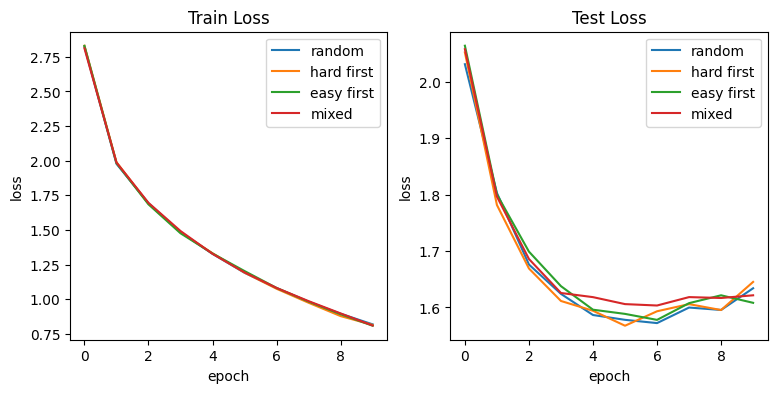

In [46]:
fig,axes = plt.subplots(1,2,figsize=(9,4))
for key,value in losses_train_history.items():
  axes[0].plot(range(n_epochs),tensor_list_to_list(value)[-10:],label=str(key))
axes[0].set_title('Train Loss')
for key,value in losses_val_history.items():
  axes[1].plot(range(n_epochs),tensor_list_to_list(value)[-10:],label=str(key))
axes[1].set_title('Test Loss')
for ax in axes:
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

plt.savefig('4schemes_tr0.5.png')

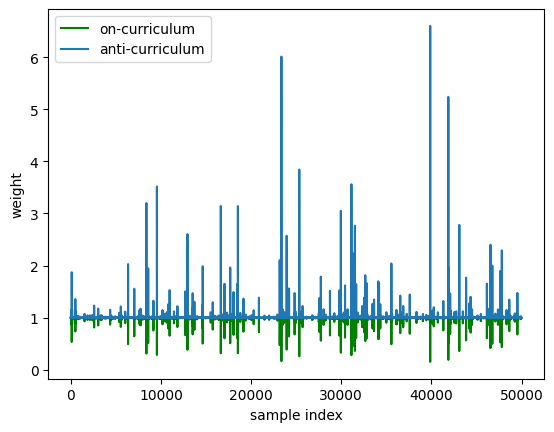

In [37]:
num_samples = 50000
on_curr_weights = 1. / (loss_per_object + 1.0)**(1.1) 
anti_curr_weights = 1. / (loss_per_object + 1.0)**(-1.1) 
plt.plot(range(num_samples),on_curr_weights.cpu().numpy(),label='on-curriculum',c='green')
plt.plot(range(num_samples),anti_curr_weights.cpu().numpy(),label='anti-curriculum')
plt.xlabel('sample index')
plt.ylabel('weight')
plt.legend()
plt.savefig('sample weights.png')